---
# Argimiro Arratia @2021 Computational Finance
# **Factor Models + Sentiment: comparison of covariance matrix estimations via different factor models including Sentimental indicators**
_Translated from R script to Python by Yikai Qiu and Joel Castaño Fernández_

http://computationalfinance.lsi.upc.edu

---

We  compare the following different factor models:

* Sample covariance matrix
* Macroeconomic 1-factor model
* Fundamental 3-factor Fama-French model
* Sentimental factor model

We will estimate the models during a training phase and then we will compare
how well the estimated covariance matrices do compared to the sample covariance
matrix of the test phase. The estimation error will be evaluated in terms of the Frobenius norm F as well as the PRIAL (PeRcentage Improvement in Average Loss): which goes to 0 when the estimation tends to the sample covariance matrix and goes to 100 when the estimation tends to the true covariance matrix.

In [1]:
import pickle
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.linalg import solve, norm
from scipy.cluster.hierarchy import fcluster

/home/clarice/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def log_return(df):
    return np.log(df).diff().drop(index=df.index[0], axis=0, inplace=False)

def na_fill(df):
    # Simulates `na.fill(as.xts(rowAvgs(df),order.by=index(df)),"extend")`
    return df.interpolate(method="linear").fillna(method="bfill")

def create_index(df):
    # the linear method already does ffill for the tail values
    return na_fill(df.mean(axis=1, skipna=False))

def cov2cor(df):
    ind = df.index
    col = df.columns
    sigma = np.sqrt(np.diag(df))
    return df.div(pd.DataFrame(np.outer(sigma, sigma), index=ind, columns=col))

def clusterplot(cov, ncluster=6):
    sns.set(style='white')
    sns_plot = sns.clustermap(cov2cor(cov), cmap='vlag_r', robust=True, method="complete", vmin=-1, vmax=1)
    plt.setp(sns_plot.ax_heatmap.yaxis.get_majorticklabels(), color='red', fontSize=14)
    plt.setp(sns_plot.ax_heatmap.xaxis.get_majorticklabels(), color='red', fontSize=14)
    plt.title("Correlation")

    Z = sns_plot.dendrogram_row.linkage
    clusters = list(fcluster(Z, ncluster, criterion='maxclust'))
    assign_cluster = dict((k, clusters[k]) for k in range(len(cov.columns)))
    assigned_idx = [assign_cluster[idx] for idx in sns_plot.dendrogram_row.reordered_ind]
    i = 0
    while i < len(assigned_idx):
        cluster = assigned_idx[i]
        counter = 0
        while i < len(assigned_idx) and assigned_idx[i] == cluster:
            counter += 1
            i += 1
        sns_plot.ax_heatmap.add_patch(plt.Rectangle(
            xy=(i-counter, i-counter),
            width=counter,
            height=counter,
            fill=None, color='black', lw=1.5
        ))
    plt.show()

# 0. Prepare data

In [3]:
# List of dataframes contain "adjusted","BBr","PNlog"
# from 2015-01-02 to 2020-06-09 for stocks
# "AAPL" "ABBV" "AMZN" "DB"   "DIS"  "FB" "GOOG"
# "HAL" "HSBC" "JPM"  "KO"   "MCD"  "MSFT" "PFE"  "XOM"
import os
current_directory = os.getcwd()
dataset = pd.read_pickle(f'{current_directory}/Inputs/dataset.pkl')

# Fama-French factors
# Maintain by French at
# url = "http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"

# fama_lib = pd.read_csv("F-F_Research_Data_Factors_daily.CSV", skiprows=4, skipfooter=1, index_col=0, engine='python')
fama_lib = pd.read_csv(f'{current_directory}/Inputs/F-F_Research_Data_Factors_daily.CSV', skiprows=4, skipfooter=1, index_col=0, engine='python')
fama_lib.index = pd.to_datetime(fama_lib.index, format="%Y%m%d")
fama_lib = fama_lib.iloc[:, 0:3] # We only use the first 3 columns

# # Read SP500 index (2015-01 to 2019-12) & compute returns
# SP500_index = pd.read_csv("SP500.csv", index_col=0)
# SP500_index.index = pd.to_datetime(SP500_index.index, format="%Y-%m-%d")

# Prepare stock data
begin_date = "2018-01-01"  # "2015-01-01" # not including
end_date = "2019-12-20" #"2019-12-20" #"2017-12-31" # including
stockPrices = dataset["adjusted"].truncate(
    before=begin_date,
    after=end_date
)

X = log_return(stockPrices)
T, N = X.shape  # nrow and ncol

F_FamaFrench = fama_lib.loc[X.index]/100   # Fama-French factors
# f_SP500 = log_return(SP500_index)          # SP500 log return
BBrMkt = create_index(dataset["BBr"])/100  # BBr Market index
PNlogMkt = create_index(dataset["PNlog"])  # PNlog Market index
SentIndx = PNlogMkt.loc[X.index]           # Sentiment index

# FamaFrench + Sent index
FFS = na_fill(pd.merge(
    fama_lib.loc[X.index], SentIndx.rename("SentIndx"),
    left_index=True, right_index=True
))

# # Sp500 + Sent index
# SPS = na_fill(pd.merge(
#     f_SP500.loc[X.index], SentIndx.rename("SentIndx"),
#     left_index=True, right_index=True
# ))

# split data into training and test data
T_trn = round(0.5*T)
X_trn = X.iloc[0:T_trn, ]
X_tst = X.iloc[T_trn:T, ]
F_FamaFrench_trn = F_FamaFrench.iloc[0:T_trn, ]
F_FamaFrench_tst = F_FamaFrench.iloc[T_trn:T, ]
# f_SP500_trn = f_SP500.iloc[0:T_trn, ]
# f_SP500_tst = f_SP500.iloc[T_trn:T, ]
SentIndx_trn = SentIndx.iloc[0:T_trn,]
SentIndx_tst = SentIndx.iloc[T_trn:T,]
FFS_trn = FFS.iloc[0:T_trn,]
FFS_tst = FFS.iloc[T_trn:T,]
# SPS_trn = SPS.iloc[0:T_trn,]
# SPS_tst = SPS.iloc[T_trn:T,]

# 1. Models

In [4]:
# Estimate the different factor models with the training data:
Sigma_SCM = X_trn.cov()  # Sample covariance matrix

## 1.b. 1-factor model SentInx

In [5]:

F = SentIndx_trn.copy().to_frame()
F.insert(0, 'ones', 1)
Gamma = pd.DataFrame(solve(F.T @ F, F.T.to_numpy() @ X_trn.to_numpy()).T, columns=["alpha", "beta"])
alpha = Gamma["alpha"]
beta = Gamma["beta"]
E = pd.DataFrame((X_trn.T - Gamma.to_numpy() @ F.to_numpy().T).T, index=X_trn.index)
Psi_Sent = (E.T @ E) / (T_trn - 2)
Sigma_SentInx = SentIndx_trn.var() * np.outer(beta, beta) + np.diag(np.diag(Psi_Sent))
#Sigma_SentInx = beta @ SentIndx_trn.cov() @ beta.T + np.diag(np.diag(Psi_Sent))

## 1.c. Fama-French 3-factor model

In [6]:

F = F_FamaFrench_trn.copy()
F.insert(0, 'ones', 1)
Gamma = pd.DataFrame(solve(F.T @ F, F.T.to_numpy() @ X_trn.to_numpy()).T, columns=["alpha", "beta1", "beta2", "beta3"])
alpha = Gamma["alpha"]
B = Gamma[["beta1", "beta2", "beta3"]]
E = pd.DataFrame((X_trn.T - Gamma.to_numpy() @ F.to_numpy().T).T, index=X_trn.index)
PsiFF = (E.T @ E) / (T_trn - 4)
Sigma_FamaFrench = B.to_numpy() @ F_FamaFrench_trn.cov() @ B.to_numpy().T + np.diag(np.diag(PsiFF))

## 1.d. Fama-French + Sentiment 4-factor model

In [7]:
F = FFS_trn.copy()
F.insert(0, 'ones', 1)
Gamma = pd.DataFrame(solve(F.T @ F, F.T.to_numpy() @ X_trn.to_numpy()).T, columns=["alpha", "beta1", "beta2", "beta3", "beta4"])
alpha = Gamma["alpha"]
B = Gamma[["beta1", "beta2", "beta3", "beta4"]]
E = pd.DataFrame((X_trn.T - Gamma.to_numpy() @ F.to_numpy().T).T, index=X_trn.index)
PsiFFS = (E.T @ E) / (T_trn - 4)
Sigma_FFS = B.to_numpy() @ FFS_trn.cov() @ B.to_numpy().T + np.diag(np.diag(PsiFFS))

# 2. Visualization

## 2.1. Correlation plot

To see finer details of the interdependency of the stocks, we should first remove the market or, equivalently, plot $\Psi$ (`Psi`).

AttributeError: Text.set() got an unexpected keyword argument 'fontSize'

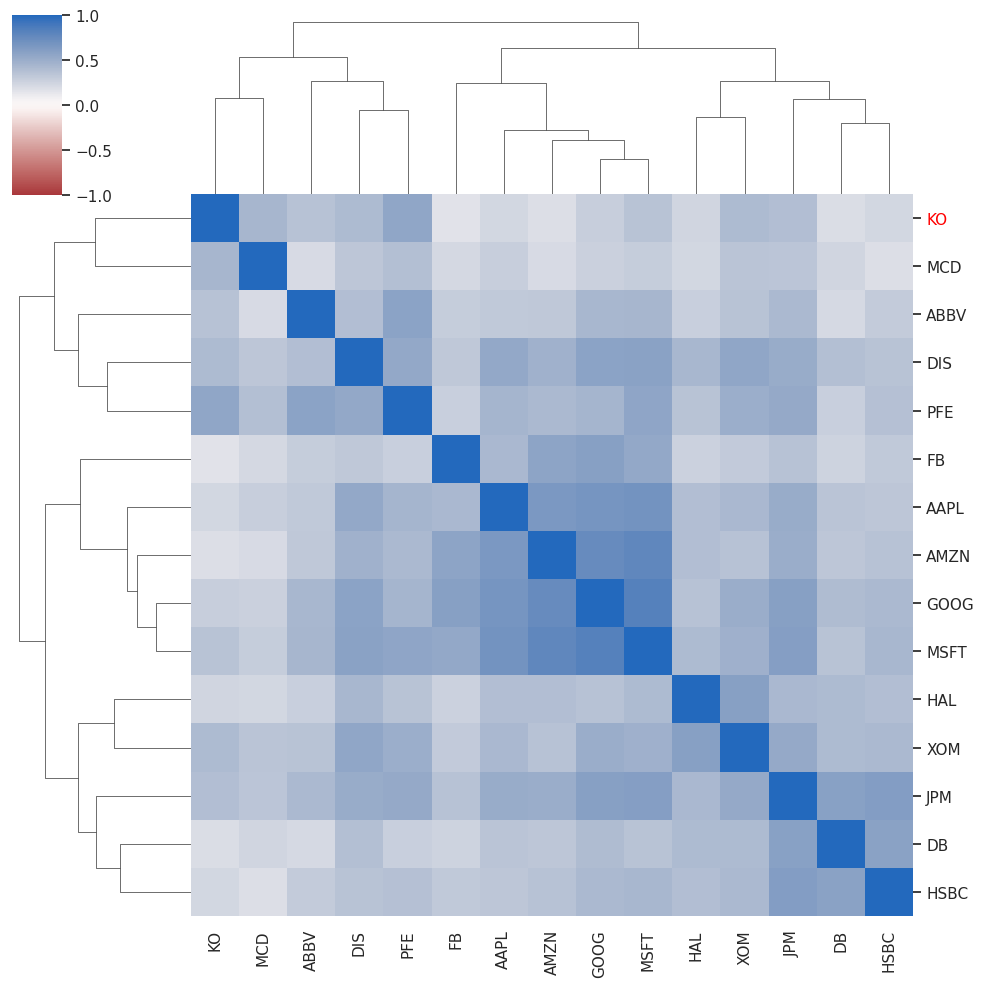

In [10]:
Psi = Psi_Sent

numclust = 6 #5 #3
clusterplot(Psi, numclust)

## 2.2. Compare the different estimates in the test data

In [9]:
Sigma_true = X_tst.cov()

# ntype = 2    # Square Error
ntype = "fro"  # Frobenious
error = pd.DataFrame({
    "SCM": norm(Sigma_SCM.to_numpy() - Sigma_true.to_numpy(), ord=ntype),
    # "SP500": norm(Sigma_SP500 - Sigma_true.to_numpy(), ord=ntype),
    "SentInd": norm(Sigma_SentInx - Sigma_true.to_numpy(), ord=ntype),
    "FamaFrench": norm(Sigma_FamaFrench - Sigma_true.to_numpy(), ord=ntype),
    "FFwSent": norm(Sigma_FFS.to_numpy() - Sigma_true.to_numpy(), ord=ntype)
    # "SPwSent": norm(Sigma_SPS.to_numpy() - Sigma_true.to_numpy(), ord=ntype)
}, index=[0])

print(
f"""
ntype: {ntype}
begin_date, end_date: {begin_date}, {end_date}
{error}
""")

## results with ntype="F"
##period: "2015-01-01" -- "2017-12-31"
## SCM          SP500         SentInd     FamaFrench    FFwSent      SPwSent
## 0.0013375661 0.0013668716 0.0009558232 0.0013449131  0.0013446866 0.0013683905

##period: "2017-01-01" -- 2019-12-20
## SCM          SP500         SentInd     FamaFrench     FFwSent      SPwSent
##0.0007881752 0.0014819731 0.0014808638 0.0008278798 0.0008274631  0.0008515856

##period: "2018-01-01" -- "2019-12-20"
# SCM           SP500     SentInd     FamaFrench    FFwSent   SPwSent
# 0.001062601 0.001314912 0.001304737 0.001080412 0.001080261 0.001102308

##period: "2015-01-01" -- 2019-12-20
## SCM          SP500         SentInd     FamaFrench     FFwSent      SPwSent
## 0.0005474218 0.0006260718 0.0012638483 0.0005925660 0.0005926426  0.0006264030

# order = ["SCM", "SP500", "SentInd", "FamaFrench", "FFwSent", "SPwSent"]
order = ["SCM", "SentInd", "FamaFrench", "FFwSent"]
alt.Chart(error.melt(value_name='error')).mark_bar().encode(
    x = alt.X('variable', title='', axis=alt.Axis(labelAngle=0), sort=order),
    y = 'error',
    color = alt.value("mediumaquamarine")
).properties(
    title="Error in estimation of covariance matrix",
    height=300,
    width=400
)


ntype: fro
begin_date, end_date: 2018-01-01, 2019-12-20
        SCM   SentInd  FamaFrench  FFwSent
0  0.001063  0.001305     0.00108  0.00108



alt.Chart(...)

In [12]:
ref = norm(Sigma_SCM - Sigma_true, ord=ntype)**2
PRIAL = 100*(ref - error**2)/ref
print(f"""
ntype: {ntype}
begin_date, end_date: {begin_date}, {end_date}
{PRIAL}
""")

## results with ntype="F"
##period: "2015-01-01" -- "2017-12-31"
# SCM         SP500    SentInd    FamaFrench    FFwSent  SPwSent
# 0.000000  -4.429915  48.934849  -1.101584  -1.067530  -4.662129

##period: "2017-01-01" -- 2019-12-20
#SCM        SP500    SentInd    FamaFrench    FFwSent   SPwSent
#0.00000 -253.53723 -253.00818  -10.32885  -10.21780  -16.73770

##period: "2018-01-01" -- "2019-12-20"
# SCM         SP500    SentInd    FamaFrench    FFwSent  SPwSent
# 0.000000  -53.127359 -50.766802  -3.380414  -3.351638  -7.613154

##period: "2015-01-01" -- 2019-12-20
#SCM      SP500    SentInd FamaFrench    FFwSent   SPwSent
#0.00000 -30.79891 -433.02268  -17.17345  -17.20375  -30.93734

# order = ["SCM", "SP500", "SentInd", "FamaFrench", "FFwSent", "SPwSent"]
order = ["SCM", "SentInd", "FamaFrench", "FFwSent"]
alt.Chart(PRIAL.melt(value_name='error')).mark_bar().encode(
    x = alt.X('variable', title='', axis=alt.Axis(labelAngle=0), sort=order),
    y = 'error',
    color = alt.value("tan")
).properties(
    title="PRIAL for estimation of covariance matrix",
    height=300,
    width=400
)


ntype: fro
begin_date, end_date: 2018-01-01, 2019-12-20
   SCM      SP500    SentInd  FamaFrench   FFwSent   SPwSent
0  0.0 -53.127359 -50.766802   -3.380414 -3.351638 -7.613154



alt.Chart(...)